In [1]:
import os 
import re

import numpy as np
import math
import tiffspect

import librosa
import librosa.display

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
k_soundsPerClass=125 # must divide the total number of sounds evenly!

In [2]:
# First some utilities, and the function we want to use to classify our spectrograms 

def weightedCentroid(spect) :
    """
    param: spect - a magnitude spectrum
    Returns the spectral centroid averaged over frames, and weighted by the rms of each frame
    """
    cent = librosa.feature.spectral_centroid(S=spect)
    rms = librosa.feature.rmse(S=spect)
    avg = np.sum(np.multiply(cent, rms))/np.sum(rms)
    return avg

def log2mag(S) : 
    """ Get your log magnitude spectrum back to magnitude"""
    return np.power(10, np.divide(S,20.))

def spectFile2Centroid(fname) :
    """ Our spect files are in log magnitude, and in tiff format"""
    D1, _ = tiffspect.Tiff2LogSpect(fname)
    D2 = log2mag(D1)
    return weightedCentroid(D2)


wc is 3327.36939464
[[ 2560.46     0.01]
 [ 2552.36     0.01]
 [ 2129.48     0.01]
 ..., 
 [ 2156.65     0.01]
 [ 2108.98     0.01]
 [ 2260.75     0.01]]


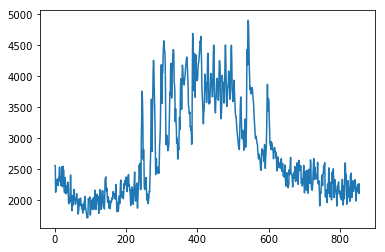

In [3]:
# just testing code, demonstrating how to visualize som of the data
wc = spectFile2Centroid('esc50spect//205 - Chirping birds/5-242491-A.tif')
print ('wc is ' + str(wc))

D1, _ = tiffspect.Tiff2LogSpect('esc50spect//205 - Chirping birds/5-242491-A.tif')
D2 = log2mag(D1)
wcs = weightedCentroid(D2)
cent = librosa.feature.spectral_centroid(S=D2)
plt.plot(cent[0])

rms = librosa.feature.rmse(S=D2)
np.set_printoptions(precision=6)
np.set_printoptions(suppress=True)
print(np.column_stack((np.transpose(np.round(cent,2)),np.transpose(np.round(rms,2)))))


In [4]:
# Next, some utilities for managing files
#----------------------------------------

def fullpathfilenames(directory): 
    '''Returns the full path to all files living in directory (the leaves in the directory tree)
    '''
    fnames = [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(directory)) for f in fn]
    return fnames

def esc50files(directory, regexString) :
    filenames = fullpathfilenames(directory)
    return [fname for fname in filenames if re.match(regexString, fname)]

def addClass2Filename(fname, cname, action="move") : 
    newname = re.sub('.tif', '._'+ str(cname) + '_.tif', fname)
    if (action == "move") :
        os.rename(fname, newname)
    else :
        print(newname)
    
def filestats (filenames, func) :
    stats = [[fname, func(fname)] for fname in filenames]
    return stats

In [5]:
def createBalancedClassesWithFunc(topDirectory, regexString, func, numPerClass, action="move") :
    """
    Groups files in topDirectory matching regexString by the single number returned by func.
    Each group will have numPerClass files in it (the total number of files must be divisible by numPerClass)
    Renames them using their group index, gidx: origFilename.tif -> origFilename._gidx_.tif
    if action="move, files are renames. Otherwise, the new names are just printed to console.
    """
    wholelist=esc50files(topDirectory, regexString)
    stats = filestats(wholelist, func)
    stats_ordered = sorted(stats, key=lambda a_entry: a_entry[1])
    classes=np.array(stats_ordered)[:,0].reshape(-1, numPerClass)
    for i in range(len(classes)) :
        for j in range(len(classes[i])) :
            addClass2Filename(classes[i,j],i, action)

    return stats, stats_ordered #returns stuff just for viewing 

#--------------------------------------------------------------------------------
#if you got yourself in trouble, and need to remove all the secondary classnames:
def removeAllSecondaryClassNames(directory) :
    """Revomve ALL the 2ndary class names (of the form ._cname_) from ALL files in the directory restoring them to their original"""
    for fname in fullpathfilenames(directory) :
        m = re.match('.*?(\._.*?_)\.tif$', fname)  #grabs the string of all secondary classes if there is a seq of them
        if (m) :
            newname = re.sub(m.group(1), '', fname)
            print('Will move ' + fname + '\n to ' + newname)
            os.rename(fname, newname)
        else :
            print('do nothing with ' + fname)

# Do it
This is the call to do your work. Pass in any function that takes spectral files (log mag in tif format) and processes them to return a single number 

In [7]:
#removeAllSecondaryClassNames('esc50spect')
stats, stats_ordered  = createBalancedClassesWithFunc('esc50spect', '.*/([1-5]).*', spectFile2Centroid, k_soundsPerClass, action="print")
#stats, stats_ordered  = createBalancedClassesWithFunc('/Volumes/Bothways/ZCODE/TENSORFLOW/dcn_soundclass/data50', '.*/(train|validate)/([1-5]).*', spectFile2Centroid, 250, action="print")

#change "print" to "move" to actually change the filenames:
#stats, stats_ordered  = createBalancedClassesWithFunc('/Volumes/Bothways/ZCODE/TENSORFLOW/dcn_soundclass/data50', '.*/(train|validate)/([1-5]).*', spectFile2Centroid, 250, action="move")

stats, stats_ordered  = createBalancedClassesWithFunc('esc50spect', '.*/([1-5]).*', spectFile2Centroid, k_soundsPerClass, action="move")


esc50spect/210 - Thunderstorm/5-156999-B._0_.tif
esc50spect/401 - Door knock/2-134915-A._0_.tif
esc50spect/401 - Door knock/2-133889-A._0_.tif
esc50spect/210 - Thunderstorm/5-156999-D._0_.tif
esc50spect/210 - Thunderstorm/5-188495-A._0_.tif
esc50spect/501 - Helicopter/4-175000-B._0_.tif
esc50spect/501 - Helicopter/4-175000-A._0_.tif
esc50spect/210 - Thunderstorm/5-156999-C._0_.tif
esc50spect/508 - Airplane/1-43807-B._0_.tif
esc50spect/210 - Thunderstorm/3-103050-A._0_.tif
esc50spect/508 - Airplane/1-43807-C._0_.tif
esc50spect/501 - Helicopter/4-175000-C._0_.tif
esc50spect/401 - Door knock/4-261068-A._0_.tif
esc50spect/505 - Engine/1-62565-A._0_.tif
esc50spect/501 - Helicopter/5-177957-D._0_.tif
esc50spect/501 - Helicopter/3-150979-A._0_.tif
esc50spect/210 - Thunderstorm/3-124600-A._0_.tif
esc50spect/210 - Thunderstorm/4-125071-A._0_.tif
esc50spect/210 - Thunderstorm/1-24524-A._0_.tif
esc50spect/404 - Door - wood creaks/4-160036-A._0_.tif
esc50spect/401 - Door knock/5-256512-A._0_.tif
e

[251.86712300006849,
 799.4665323900366,
 1057.5433213214869,
 1271.5815134838167,
 1482.4553698281527,
 1669.8918365104241,
 1860.7472900797943,
 2021.4035286957937,
 2178.2839836329795,
 2371.6152292805018,
 2583.9929145295996,
 2832.0083827033427,
 3073.5300369475631,
 3371.5806383123477,
 3767.9272186910471,
 4614.6980978378442]

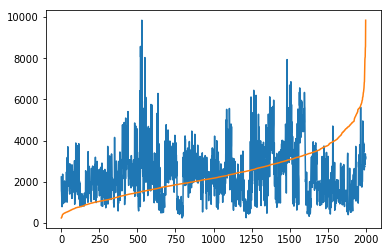

In [9]:
# Analysis of the results of your classification
#------------------------------------------------

plt.plot(np.array(stats)[:,1])         # centroids of files in order read in (plotted in blue below)
plt.plot(np.array(stats_ordered)[:,1]) #centroids from min to max (plotted in orange below)

#Just for our own info, and paper writeups:
breaks=[stats_ordered[i][1] for i in range(0, 2000, k_soundsPerClass)] # [0, 125, 250, 375, 500, 625, 750, 875 1000, 1125, 1250, 1375, 1500, 1625, 1750, 1875]
breaks